In [65]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import requests
from datetime import datetime
import seaborn as sns
from pyecharts.charts import Bar
from pyecharts import options as opts
import folium



In [26]:
def recup_data_arrete(url, proxy=False):
        proxies = {
            'http': 'http://proxyvip.national.agri:8080',
            'https': 'http://proxyvip.national.agri:8080',
        }
        if proxy == False:
            response = requests.get(url)
        else:
            response = requests.get(url,  proxies=proxies)
        if response.status_code != 200:
            return("pas de connexion")
        else:
            data = pd.read_csv(url)
            return(data)

In [27]:
urls = {
    '2010' : "https://www.data.gouv.fr/fr/datasets/r/d6cb1826-6cc8-4709-85fd-433db23aa951",    
    '2011' : "https://www.data.gouv.fr/fr/datasets/r/227149be-cd8b-4e59-a1a9-0840ef7f0a24",
    '2012' : "https://www.data.gouv.fr/fr/datasets/r/43864992-e79b-449e-9d7d-93dad9b9df59",
    '2013' : "https://www.data.gouv.fr/fr/datasets/r/f9c1da33-19f4-499d-88cc-b3c247484215",
    '2014' : "https://www.data.gouv.fr/fr/datasets/r/c68362d9-93ff-46bc-99a6-35d506855dae",    
    '2015' : "https://www.data.gouv.fr/fr/datasets/r/98cb1f80-f296-4eae-a0b3-f236fc0b9325",
    '2016' : "https://www.data.gouv.fr/fr/datasets/r/fbd87d0b-a504-49e2-be6e-66a96ca4e489",
    '2017' : "https://www.data.gouv.fr/fr/datasets/r/ab886886-9b64-47ca-8604-49c9910c0b74",
    '2018' : "https://www.data.gouv.fr/fr/datasets/r/8ba1889e-5496-47a6-8bf3-9371086dd65c",
    '2019' : "https://www.data.gouv.fr/fr/datasets/r/ed2e6cfa-1fe7-40a6-95bb-d9e6f99a78a0",
    '2020' : "https://www.data.gouv.fr/fr/datasets/r/d16ae5b1-6666-4caa-930c-7993c4cd4188",
    '2021' : "https://www.data.gouv.fr/fr/datasets/r/c23fe783-763f-4669-a9b7-9d1d199fcfcd",
    '2022' : "https://www.data.gouv.fr/fr/datasets/r/0fee8de1-c6de-4334-8daf-654549e53988",
    '2023' : "https://www.data.gouv.fr/fr/datasets/r/782aac32-29c8-4b66-b231-ab4c3005f574"
}
for key, value in urls.items():
    # Création du nom de l'objet en concaténant "data_" avec la clé
    nom_objet = "data_" + key

    # Création de l'objet avec le nom spécifié
    globals()[nom_objet] = recup_data_arrete(value, proxy=True)

URLError: <urlopen error [WinError 10060] Une tentative de connexion a échoué car le parti connecté n’a pas répondu convenablement au-delà d’une certaine durée ou une connexion établie a échoué car l’hôte de connexion n’a pas répondu>

In [85]:
def maj_dataframe(data_frame):
    data_frame['debut_validite_arrete'] = pd.to_datetime(data_frame['debut_validite_arrete'])
    data_frame['fin_validite_arrete'] = pd.to_datetime(data_frame['fin_validite_arrete'])
    data_frame['duree_validite_arrete'] = (data_frame['fin_validite_arrete'] - data_frame['debut_validite_arrete']).dt.days
    data_frame['annee'] = data_frame['debut_validite_arrete'].dt.year
    data_frame = data_frame[['id_arrete', 'id_zone', 'annee', 'numero_niveau', 'nom_niveau', 'duree_validite_arrete']]
    return(data_frame)

In [ ]:
dataframes_maj = []
for annee in urls.keys():
    # Récupération du DataFrame correspondant à l'année
    df = globals().get(f'data_{annee}')
    
    # Vérification si le DataFrame existe
    if df is not None:
        # Application de la fonction maj_dataframe(df)
        df_maj = maj_dataframe(df)
             
        # Ajout du DataFrame mis à jour à la liste
        dataframes_maj.append(df_maj)

# Concaténation de tous les DataFrames avec le suffixe "_maj"
data_tous_arretes = pd.concat(dataframes_maj, axis=0)

In [ ]:
data_agrege = data_tous_arretes[data_tous_arretes['nom_niveau']!="Absence de restriction"].groupby(['annee','nom_niveau']).agg(
        total_duree = ('duree_validite_arrete', 'sum'),
        nombre_observations=('nom_niveau', 'size')
    )

data_agrege = data_agrege.reset_index(level = ['annee','nom_niveau'])
data_agrege

,annee,nom_niveau,total_duree,nombre_observations
0,2010,Alerte,1041.0,12
1,2010,Arrêt des prélèvements non prioritaires,122.0,3
2,2010,Crise,531.0,8
3,2010,Crise modérée,404.0,8
4,2010,Crise renforcée,1982.0,10
...,...,...,...,...
57,2023,Alerte,36062.0,595
58,2023,Alerte renforcée,23108.0,372
59,2023,Crise,7962.0,126
60,2023,Vigilance,121080.0,1895


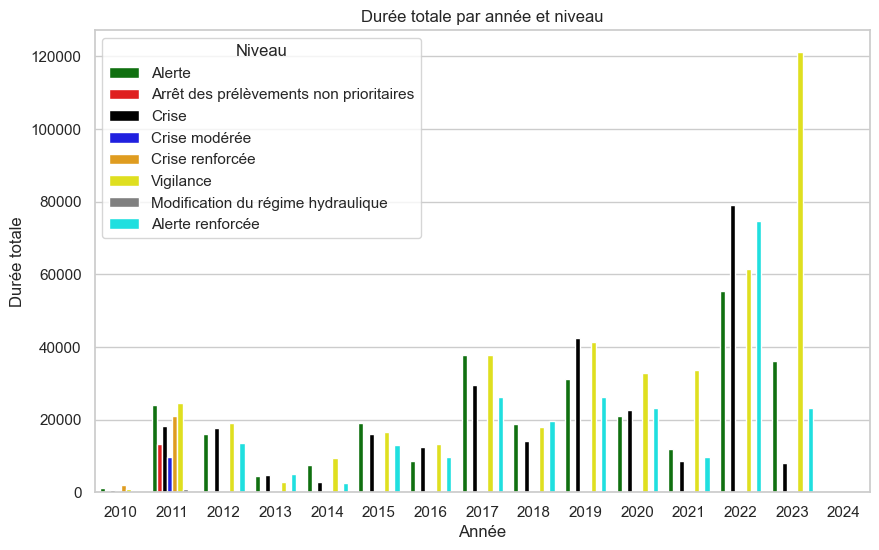

In [ ]:
# Couleurs pour chaque niveau
couleurs = {
            'Crise modérée' : "blue", 
            'Crise' : "black",  
            'Vigilance' : "yellow",  
            'Alerte' : "green", 
            'Arrêt des prélèvements non prioritaires' : "red",  
            'Crise renforcée' : "orange", 
            'Absence de restriction' : "purple",  
            'Modification du régime hydraulique' : "grey", 
            'Alerte renforcée' : "cyan" 
            }  

# Graphique à barres empilées
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

sns.barplot(
    data=data_agrege,
    x='annee',
    y='total_duree',
    hue='nom_niveau',
    palette=couleurs,
    estimator=sum,
    errorbar=None
)

plt.title('Durée totale par année et niveau')
plt.xlabel('Année')
plt.ylabel('Durée totale')
plt.legend(title='Niveau')

plt.show()

In [ ]:
data_pivot = data_agrege.pivot(index='annee', columns='nom_niveau', values='total_duree').reset_index()
data_pivot.head()

nom_niveau,annee,Alerte,Alerte renforcée,Arrêt des prélèvements non prioritaires,Crise,Crise modérée,Crise renforcée,Modification du régime hydraulique,Vigilance
0,2010,1041.0,NaN,122.0,531.0,404.0,1982.0,NaN,872.0
1,2011,24146.0,NaN,13390.0,18236.0,9750.0,21049.0,774.0,24562.0
2,2012,15926.0,13457.0,NaN,17705.0,NaN,NaN,NaN,18973.0
3,2013,4364.0,4912.0,NaN,4724.0,NaN,NaN,NaN,2688.0
4,2014,7594.0,2443.0,NaN,2774.0,NaN,NaN,NaN,9512.0


In [ ]:
data_pivot.annee.tolist()

[2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024]

In [ ]:

(
    Bar(
        opts.InitOpts(
            #theme = ThemeType.DARK,
            width = "1024px",
            height = "600px"
        )
    )
    .add_xaxis(data_pivot.annee.tolist())
    .add_yaxis(
        "Vigilance",
        data_pivot["Vigilance"].tolist(),
        stack= "Ad",
        color="#FAED93",
    ).add_yaxis(
        "Alerte",
        data_pivot["Alerte"].tolist(),
        stack= "Ad",
        color="#FAC939",
    ).add_yaxis(
        "Alerte renforcée",
        data_pivot["Alerte renforcée"].tolist(),
        stack= "Ad",
        color="#FA78C5",
    ).add_yaxis(
        "Arrêt des prélèvements non prioritaires",
        data_pivot["Arrêt des prélèvements non prioritaires"].tolist(),
        stack= "Ad",
        color="#FA9778",
    ).add_yaxis(
        "Crise modérée",
        data_pivot["Crise modérée"].tolist(),
        stack= "Ad",
        color="#FB6C86",
    ).add_yaxis(
        "Crise",
        data_pivot["Crise"].tolist(),
        stack= "Ad",
        color="#FA2048",
    ).add_yaxis(
        "Crise renforcée",
        data_pivot["Crise renforcée"].tolist(),
        stack= "Ad",
        color="#7A1023",
    ).set_global_opts(
        # Configure other options for the chart (e.g., title, axis labels)
        title_opts=opts.TitleOpts(title="Durée cumulée des arrêtés de sécheresse en France"),
        xaxis_opts=opts.AxisOpts(name="Année"),
        yaxis_opts=opts.AxisOpts(name="Durée totale en nombre de jours")
    ).render_notebook() # use .render_notebook() within Jupyter notebooks
)

Cartes annuelles

In [86]:
data_2010 = pd.read_csv("data/arretes_2010.csv")
data_2010.head()
                        

,unique_key_arrete_zone_alerte,id_arrete,id_zone,numero_arrete,numero_arrete_cadre,date_signature,debut_validite_arrete,fin_validite_arrete,numero_niveau,nom_niveau,statut_arrete,chemin_fichier
0,08262f1d29c0d9e189e59e1919c48e0b,20870,4065,2010000254,NaN,2010-08-01,2010-08-04,2010-09-04,4,Crise modérée,Terminé,NaN
1,ddcc3174be5cd47e96c0ba761d149e1f,20870,4067,2010000254,NaN,2010-08-01,2010-08-04,2010-09-04,5,Crise,Terminé,NaN
2,5da9b333656a67e109d9116533602700,20871,4184,2010-215-0006,NaN,2010-08-03,2010-08-04,2010-08-17,1,Vigilance,Terminé,NaN
3,0113a0e12cc7e7184761249cfe094d3a,20871,4185,2010-215-0006,NaN,2010-08-03,2010-08-04,2010-08-17,1,Vigilance,Terminé,NaN
4,44659d3aae0cca0be54ba1831453b760,20872,4184,2010-229-0005,NaN,2010-08-17,2010-08-18,2010-11-18,1,Vigilance,Terminé,NaN


In [87]:
data_2010_maj = maj_dataframe(data_2010)
data_2010_maj.head()

,id_arrete,id_zone,annee,numero_niveau,nom_niveau,duree_validite_arrete
0,20870,4065,2010,4,Crise modérée,31
1,20870,4067,2010,5,Crise,31
2,20871,4184,2010,1,Vigilance,13
3,20871,4185,2010,1,Vigilance,13
4,20872,4184,2010,1,Vigilance,92


In [88]:
data_2010_agrege = data_2010_maj[data_2010_maj['nom_niveau']!="Absence de restriction"].groupby(['annee','id_zone']).agg(
        total_duree = ('duree_validite_arrete', 'sum'),
        nombre_observations=('nom_niveau', 'size')
    )

data_2010_agrege = data_2010_agrege.reset_index(level = ['annee','id_zone'])
data_2010_agrege.head()

,annee,id_zone,total_duree,nombre_observations
0,2010,3248,111,1
1,2010,3250,111,1
2,2010,3253,72,1
3,2010,3295,92,1
4,2010,3654,14,1


In [67]:
data_geo_simplify = gpd.read_file("data/all_zones_simplify.json")
data_geo_simplify.head()

,id_zone,code_zone,type_zone,nom_zone,n_version,est_max_v,code_dep,nom_dep,geometry
0,3235,52_49_14,SUP,COUASNON,1,0,49,Maine-et-Loire,"POLYGON ((-0.09315 47.48083, -0.10919 47.45518..."
1,3236,54_79_6,SUP,Charente,1,0,79,Deux-Sèvres,"POLYGON ((0.01832 46.15463, 0.05323 46.16060, ..."
2,3237,94_2A_1,SUP,Zone sud,1,1,2A,Corse-du-Sud,"MULTIPOLYGON (((9.37283 41.55851, 9.37050 41.5..."
3,3238,94_2A_2,SUP,Zone nord,1,1,2A,Corse-du-Sud,"MULTIPOLYGON (((8.76369 41.92079, 8.76323 41.9..."
4,3239,94_2B_1,SUP,Departement Corse nord,1,0,2B,Haute-Corse,"POLYGON ((9.55624 42.14266, 9.54929 42.10387, ..."


In [68]:
geo_merge = data_geo_simplify.merge(data_2010_agrege, on = 'id_zone')
geo_merge.head()

,id_zone,code_zone,type_zone,nom_zone,n_version,est_max_v,code_dep,nom_dep,geometry,annee,total_duree,nombre_observations
0,3248,11_95_02,SUP,BASSIN VERSANT DE LA PLAINE DE FRANCE ET DU PA...,1,0,95,Val-d'Oise,"POLYGON ((2.59468 49.04772, 2.53542 49.02378, ...",2010,111,1
1,3250,11_95_01,SUP,BASSIN VERSANT DU VEXIN,1,0,95,Val-d'Oise,"POLYGON ((2.23436 49.16577, 2.21636 49.15438, ...",2010,111,1
2,3253,11_91_04,SUP,Bassin de l'Essonne et ses affluents,1,0,91,Essonne,"POLYGON ((2.32562 48.59324, 2.32046 48.61532, ...",2010,72,1
3,3295,21_52_01,SUP,Saulx-Ornain,1,0,52,Haute-Marne,"MULTIPOLYGON (((5.53315 48.32574, 5.44735 48.3...",2010,92,1
4,3654,43_39_0001,SUP,Plateaux calcaires jurassiens_dpt 39,1,0,39,Jura,"POLYGON ((5.29961 46.41732, 5.32549 46.42991, ...",2010,14,1


In [69]:
colonnes_selectionnees = ['id_zone','geometry', 'code_zone','nom_zone','total_duree']
gdf_selection = geo_merge.loc[:, colonnes_selectionnees]

In [70]:
gdf_selection.explore(column='total_duree', tooltip=True)

In [76]:
data_geo_simplify.head()

,id_zone,code_zone,type_zone,nom_zone,n_version,est_max_v,code_dep,nom_dep,geometry
0,3235,52_49_14,SUP,COUASNON,1,0,49,Maine-et-Loire,"POLYGON ((-0.09315 47.48083, -0.10919 47.45518..."
1,3236,54_79_6,SUP,Charente,1,0,79,Deux-Sèvres,"POLYGON ((0.01832 46.15463, 0.05323 46.16060, ..."
2,3237,94_2A_1,SUP,Zone sud,1,1,2A,Corse-du-Sud,"MULTIPOLYGON (((9.37283 41.55851, 9.37050 41.5..."
3,3238,94_2A_2,SUP,Zone nord,1,1,2A,Corse-du-Sud,"MULTIPOLYGON (((8.76369 41.92079, 8.76323 41.9..."
4,3239,94_2B_1,SUP,Departement Corse nord,1,0,2B,Haute-Corse,"POLYGON ((9.55624 42.14266, 9.54929 42.10387, ..."


In [77]:
data_2010_agrege.head()

,annee,id_zone,total_duree,nombre_observations
0,2010,3248,111,1
1,2010,3250,111,1
2,2010,3253,72,1
3,2010,3295,92,1
4,2010,3654,14,1


In [90]:
import branca

In [101]:
gdf_selection['total_duree'].max()

303

In [119]:
latitude = 46.1
longitude = 2.2
m = folium.Map(location=[latitude, longitude], zoom_start=5, tiles="cartodb positron", )

colonnes_tooltip = colonnes_selectionnees.copy()
colonnes_tooltip.remove('geometry')

colonnes_tooltip_alias = []
for colonne in colonnes_tooltip:
        colonne_alias = colonne.replace("_", " ").capitalize()
        colonnes_tooltip_alias.append(colonne_alias)
        
min_value = gdf_selection['total_duree'].min()
max_value = gdf_selection['total_duree'].max()
num_elements = 6

liste_chiffres = np.linspace(min_value, max_value, num_elements)
liste_arrondie = np.round(liste_chiffres, -1).astype(int)

colormap  = branca.colormap.linear.YlOrRd_09.scale(min_value, max_value )
colormap = colormap.to_step(index=liste_arrondie)
colormap.caption = 'Durée sous arrêtés par zone (en nombre de jours cumulés)'
colormap.add_to(m)

def style_function(feature):
            nb = feature["properties"]["total_duree"]
            return {
                "fillOpacity": 0.7,
                "weight": 0,
                "fillColor": '#gray' if nb is None else colorscale(nb),
                "color": "#D9D9D9"
            }    

folium.GeoJson(gdf_selection, style_function=style_function, tooltip=folium.features.GeoJsonTooltip(
                fields=colonnes_tooltip,
                aliases=colonnes_tooltip_alias,
                sticky=True,
                opacity=0.9,
                direction='right',
            )).add_to(m)

m


NE pas lancer le code ci-dessous

In [49]:
shapefile_path = "data/all_zones.shp"
gdf = gpd.read_file(shapefile_path)
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [64]:
from shapely.geometry import Polygon
from shapely.ops import transform
from functools import partial
import pyproj

tolerance = 0.01  # Ajustez cette valeur selon vos besoins

def simplify_geometry(geom, tolerance):
    if geom and not geom.is_empty:
        if geom.is_valid:
            return geom.simplify(tolerance, preserve_topology=True)
        else:
            # Correction des géométries invalides en utilisant buffer(0)
            valid_geom = geom.buffer(0)
            return valid_geom.simplify(tolerance, preserve_topology=True)
    else:
        return None

# Fonction de projection pour éviter les problèmes avec la méthode buffer(0)
project = partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'),  # Remplacez le CRS par le CRS approprié de votre shapefile
    pyproj.Proj(init='EPSG:4326')   # Remplacez le CRS par le CRS approprié de votre shapefile
)

simplified_polygons = []
for polygon in gdf['geometry']:
    if polygon:
        projected_polygon = transform(project, polygon)  # Projection des géométries
        simplified_polygon = simplify_geometry(projected_polygon, tolerance)
        simplified_polygons.append(simplified_polygon)

simplified_gdf = gpd.GeoDataFrame(gdf.dropna(subset=['geometry']).drop('geometry', axis=1), geometry=simplified_polygons)

size_mb = simplified_gdf.memory_usage(deep=True).sum() / (1024 * 1024)
print("Taille du GeoDataFrame simplifié :", size_mb, "Mo")
output_path = "data/all_zones_simplify.json"
simplified_gdf.to_file(output_path)

c:\Users\anael.delorme\Documents\outils\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\anael.delorme\Documents\outils\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Taille du GeoDataFrame simplifié : 2.950497627258301 Mo


In [66]:
output_path = "data/all_zones_simplify.json"
simplified_gdf.to_file(output_path)